In [10]:
import torch
import numpy as np
import pinot
import math
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [11]:
# define the target
f = lambda x: torch.sin(x)

x_tr = torch.tensor(np.concatenate(
    [
        np.linspace(-3 * math.pi, -math.pi, 50),
        np.linspace(math.pi, 3 * math.pi, 50)
    ]),
    dtype=torch.float32)[:, None]

x_te = torch.tensor(np.concatenate(
    [
        np.linspace(-7 * math.pi, -3 * math.pi, 100),
        np.linspace(-math.pi, math.pi, 50),
        np.linspace(3 * math.pi, 7 * math.pi, 100)
    ]),
    dtype=torch.float32)[:, None]

x = torch.tensor(np.linspace(-7 * math.pi, 7 * math.pi, 375),
                 dtype=torch.float32)[:, None]


y_tr = f(x_tr)
y_te = f(x_te)
y = f(x)

In [13]:
dir(pinot.inference.gp.gpr)

['__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'base_gpr',
 'exact_gpr',
 'pinot']

In [12]:
net = torch.nn.Sequential(
        torch.nn.Linear(1, 50),
        torch.nn.Tanh(),
        torch.nn.Linear(50, 1))

base_kernel=pinot.inference.gp.kernels.rbf.RBF()

kernel = pinot.inference.gp.kernels.deep_kernel.DeepKernel(
    net,
    base_kernel=base_kernel)

gpr = pinot.inference.gp.gpr.variational_gpr.VGPR(kernel)

AttributeError: module 'pinot.inference.gp.gpr' has no attribute 'variational_gpr'

In [4]:
opt = torch.optim.Adam(net.parameters(), 1e-3)
for _ in range(1000):
    opt.zero_grad()
    loss = gpr.loss(x_tr, y_tr).sum()
    loss.backward()
    print(loss)
    opt.step()

tensor(216.1892, grad_fn=<SumBackward0>)
tensor(215.7786, grad_fn=<SumBackward0>)
tensor(215.3782, grad_fn=<SumBackward0>)
tensor(215.0036, grad_fn=<SumBackward0>)
tensor(214.6681, grad_fn=<SumBackward0>)
tensor(214.3800, grad_fn=<SumBackward0>)
tensor(214.1357, grad_fn=<SumBackward0>)
tensor(213.9258, grad_fn=<SumBackward0>)
tensor(213.7408, grad_fn=<SumBackward0>)
tensor(213.5731, grad_fn=<SumBackward0>)
tensor(213.4177, grad_fn=<SumBackward0>)
tensor(213.2713, grad_fn=<SumBackward0>)
tensor(213.1322, grad_fn=<SumBackward0>)
tensor(212.9991, grad_fn=<SumBackward0>)
tensor(212.8714, grad_fn=<SumBackward0>)
tensor(212.7484, grad_fn=<SumBackward0>)
tensor(212.6297, grad_fn=<SumBackward0>)
tensor(212.5149, grad_fn=<SumBackward0>)
tensor(212.4037, grad_fn=<SumBackward0>)
tensor(212.2958, grad_fn=<SumBackward0>)
tensor(212.1908, grad_fn=<SumBackward0>)
tensor(212.0883, grad_fn=<SumBackward0>)
tensor(211.9880, grad_fn=<SumBackward0>)
tensor(211.8894, grad_fn=<SumBackward0>)
tensor(211.7923,

tensor(206.1183, grad_fn=<SumBackward0>)
tensor(206.1124, grad_fn=<SumBackward0>)
tensor(206.1065, grad_fn=<SumBackward0>)
tensor(206.1007, grad_fn=<SumBackward0>)
tensor(206.0950, grad_fn=<SumBackward0>)
tensor(206.0893, grad_fn=<SumBackward0>)
tensor(206.0836, grad_fn=<SumBackward0>)
tensor(206.0781, grad_fn=<SumBackward0>)
tensor(206.0726, grad_fn=<SumBackward0>)
tensor(206.0671, grad_fn=<SumBackward0>)
tensor(206.0617, grad_fn=<SumBackward0>)
tensor(206.0564, grad_fn=<SumBackward0>)
tensor(206.0511, grad_fn=<SumBackward0>)
tensor(206.0459, grad_fn=<SumBackward0>)
tensor(206.0406, grad_fn=<SumBackward0>)
tensor(206.0355, grad_fn=<SumBackward0>)
tensor(206.0304, grad_fn=<SumBackward0>)
tensor(206.0253, grad_fn=<SumBackward0>)
tensor(206.0204, grad_fn=<SumBackward0>)
tensor(206.0154, grad_fn=<SumBackward0>)
tensor(206.0105, grad_fn=<SumBackward0>)
tensor(206.0057, grad_fn=<SumBackward0>)
tensor(206.0009, grad_fn=<SumBackward0>)
tensor(205.9961, grad_fn=<SumBackward0>)
tensor(205.9914,

tensor(205.4980, grad_fn=<SumBackward0>)
tensor(205.4969, grad_fn=<SumBackward0>)
tensor(205.4958, grad_fn=<SumBackward0>)
tensor(205.4947, grad_fn=<SumBackward0>)
tensor(205.4936, grad_fn=<SumBackward0>)
tensor(205.4926, grad_fn=<SumBackward0>)
tensor(205.4915, grad_fn=<SumBackward0>)
tensor(205.4904, grad_fn=<SumBackward0>)
tensor(205.4894, grad_fn=<SumBackward0>)
tensor(205.4883, grad_fn=<SumBackward0>)
tensor(205.4873, grad_fn=<SumBackward0>)
tensor(205.4862, grad_fn=<SumBackward0>)
tensor(205.4852, grad_fn=<SumBackward0>)
tensor(205.4842, grad_fn=<SumBackward0>)
tensor(205.4831, grad_fn=<SumBackward0>)
tensor(205.4821, grad_fn=<SumBackward0>)
tensor(205.4811, grad_fn=<SumBackward0>)
tensor(205.4801, grad_fn=<SumBackward0>)
tensor(205.4791, grad_fn=<SumBackward0>)
tensor(205.4781, grad_fn=<SumBackward0>)
tensor(205.4771, grad_fn=<SumBackward0>)
tensor(205.4761, grad_fn=<SumBackward0>)
tensor(205.4751, grad_fn=<SumBackward0>)
tensor(205.4741, grad_fn=<SumBackward0>)
tensor(205.4731,

tensor(205.3434, grad_fn=<SumBackward0>)
tensor(205.3430, grad_fn=<SumBackward0>)
tensor(205.3426, grad_fn=<SumBackward0>)
tensor(205.3423, grad_fn=<SumBackward0>)
tensor(205.3419, grad_fn=<SumBackward0>)
tensor(205.3416, grad_fn=<SumBackward0>)
tensor(205.3412, grad_fn=<SumBackward0>)
tensor(205.3408, grad_fn=<SumBackward0>)
tensor(205.3404, grad_fn=<SumBackward0>)
tensor(205.3401, grad_fn=<SumBackward0>)
tensor(205.3398, grad_fn=<SumBackward0>)
tensor(205.3394, grad_fn=<SumBackward0>)
tensor(205.3390, grad_fn=<SumBackward0>)
tensor(205.3387, grad_fn=<SumBackward0>)
tensor(205.3383, grad_fn=<SumBackward0>)
tensor(205.3380, grad_fn=<SumBackward0>)
tensor(205.3376, grad_fn=<SumBackward0>)
tensor(205.3372, grad_fn=<SumBackward0>)
tensor(205.3369, grad_fn=<SumBackward0>)
tensor(205.3366, grad_fn=<SumBackward0>)
tensor(205.3362, grad_fn=<SumBackward0>)
tensor(205.3358, grad_fn=<SumBackward0>)
tensor(205.3357, grad_fn=<SumBackward0>)
tensor(205.3352, grad_fn=<SumBackward0>)
tensor(205.3349,

tensor(205.2619, grad_fn=<SumBackward0>)
tensor(205.2627, grad_fn=<SumBackward0>)
tensor(205.2616, grad_fn=<SumBackward0>)
tensor(205.2615, grad_fn=<SumBackward0>)
tensor(205.2614, grad_fn=<SumBackward0>)
tensor(205.2604, grad_fn=<SumBackward0>)
tensor(205.2600, grad_fn=<SumBackward0>)
tensor(205.2598, grad_fn=<SumBackward0>)
tensor(205.2595, grad_fn=<SumBackward0>)
tensor(205.2592, grad_fn=<SumBackward0>)
tensor(205.2588, grad_fn=<SumBackward0>)
tensor(205.2585, grad_fn=<SumBackward0>)
tensor(205.2582, grad_fn=<SumBackward0>)
tensor(205.2580, grad_fn=<SumBackward0>)
tensor(205.2577, grad_fn=<SumBackward0>)
tensor(205.2574, grad_fn=<SumBackward0>)
tensor(205.2571, grad_fn=<SumBackward0>)
tensor(205.2567, grad_fn=<SumBackward0>)
tensor(205.2564, grad_fn=<SumBackward0>)
tensor(205.2562, grad_fn=<SumBackward0>)
tensor(205.2559, grad_fn=<SumBackward0>)
tensor(205.2558, grad_fn=<SumBackward0>)
tensor(205.2558, grad_fn=<SumBackward0>)
tensor(205.2553, grad_fn=<SumBackward0>)
tensor(205.2557,

In [6]:
y_hat_distribution = gpr.condition(x_tr, y_tr, x)

In [7]:
y_hat_distribution.sample().shape

torch.Size([375])

In [8]:
def plot():
    from pinot.inference.utils import confidence_interval
    from matplotlib import pyplot as plt

    plt.figure(figsize=(10, 6))
    # y_hat_distribution = pinot.inference.utils.condition_mixture(net, x, sampler=opt, n_samples=1000)

    nll = y_hat_distribution.log_prob(y).mean() / float(y.shape[0])

    plt.plot(x, y_hat_distribution.mean.detach().numpy(), c='k', linewidth=5)

    low, high = confidence_interval(y_hat_distribution, 0.95, n_samples=100)
    plt.fill_between(x.flatten(), low.flatten(), high.flatten(), color='k', alpha=0.1)
    
    low, high = confidence_interval(y_hat_distribution, 0.75, n_samples=100)
    plt.fill_between(x.flatten(), low.flatten(), high.flatten(), color='k', alpha=0.2)

    low, high = confidence_interval(y_hat_distribution, 0.50, n_samples=100)
    plt.fill_between(x.flatten(), low.flatten(), high.flatten(), color='k', alpha=0.3)

    low, high = confidence_interval(y_hat_distribution, 0.25, n_samples=100)
    plt.fill_between(x.flatten(), low.flatten(), high.flatten(), color='k', alpha=0.4)

    plt.scatter(x_te, y_te, label='te')
    plt.scatter(x_tr, y_tr, label='tr')
    plt.legend()
    plt.ylim(-2, 2)
    plt.title('NLL=%s' % nll.detach().numpy().round(3))

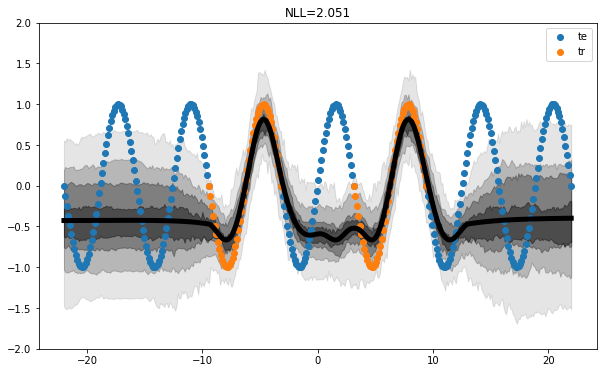

In [9]:
plot()